# Klasyfikacja ręcznie pisanych cyfr za pomocą CNN oraz Gradient Boosting

## Biblioteki oraz zestaw danych

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt                         # Wykresy
import numpy as np                                      # Macierze i typy
from sklearn import datasets                            # Wczytywanie zestawu danych
from sklearn.ensemble import GradientBoostingRegressor  # Algorytm gradient boosting
from sklearn.metrics import mean_squared_error          # Obliczanie błędu modelu
from sklearn.utils import shuffle                       # Randomizowanie zestawu danych

In [55]:
# TODO: wczytać MNIST, a nie ten uproszczony zbiór
digits = datasets.load_digits()

## Analiza danych

In [56]:
print("Zbiór danych składa się z", digits.data.shape[0], "instancji.")

Zbiór danych składa się z 1797 instancji.


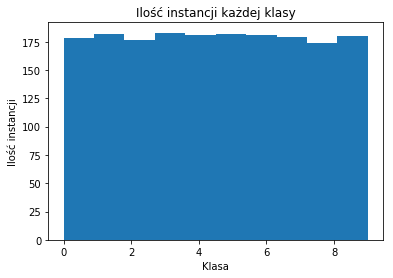

In [57]:
plt.title("Ilość instancji każdej klasy")
plt.xlabel("Klasa")
plt.ylabel("Ilość instancji")
_ = plt.hist(digits.target, bins=len(digits.target_names))

In [58]:
print("Każda instancja posiada", digits.data.shape[1], "cechy.")

Każda instancja posiada 64 cechy.


Zestaw danych składa się z obrazów 8 x 8 px, przedstawiających ręcznie pisane cyfry.
Poniżej zaprezentowana jest pierwsza instancja zestawu.

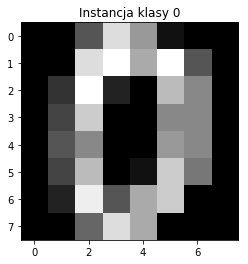

In [59]:
plt.title("Instancja klasy {}".format(digits.target[0]))
_ = plt.imshow(np.reshape(digits.data[0], (8, 8)), cmap='gray')

Wg, żródła[^1], większość ludzi preferuje oglądać obrazy rozmazane zamiast obrazów w małej rozdzielczości.
W związku z tym, od tego momentu przy wyświetlaniu obrazów posłużymy się interpolacją.

[^1]: https://matplotlib.org/users/image_tutorial.html 

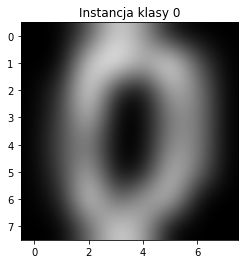

In [60]:
plt.title("Instancja klasy {}".format(digits.target[0]))
_ = plt.imshow(np.reshape(digits.data[0], (8, 8)), cmap='gray', interpolation='bicubic')

Aby zapoznać czytelnika z zestawem danych, poniżej prezentujemy jeszcze kilka instancji różnych klas.

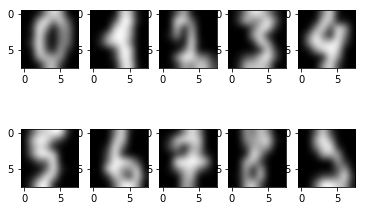

In [61]:
for idx in range(0, 10):
    plt.subplot(2, 5, 1 + idx)
    _ = plt.imshow(np.reshape(digits.data[10 + idx], (8, 8)), cmap='gray', interpolation='bicubic')

## Przygotowanie danych do procesu uczenia

In [62]:
x, y = shuffle(digits.data, digits.target, random_state=13)
x = x.astype(np.float32)
offset = int(x.shape[0] * 0.9)
x_train, y_train = x[:offset], y[:offset]
x_test, y_test = x[offset:], y[offset:]

## Budowanie modelu

In [63]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

### Ewaluacja modelu

MSE: 1.4648


Text(0, 0.5, 'Deviance')

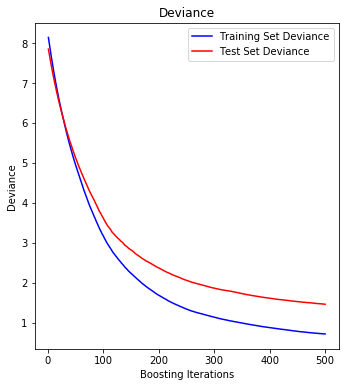

In [66]:
mse = mean_squared_error(y_test, clf.predict(x_test))
print("MSE: %.4f" % mse)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(x_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

## Użycie modelu w praktyce

## Podsumowanie